## Models with pre-processing and cross validation

### Data preparation

#### Importing required libraries

In [ ]:
!pip install matplotlib==3.4

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_decomposition import PLSRegression
import pandas as pd
import joblib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#### Pre-processing
- Savitzty-Golay
- Baseline correction for raman spectra

In [3]:
# savgol filter
class SavgolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_of_points=0, degree=1):
        self.num_of_points = num_of_points
        self.degree = degree
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # print(self.num_of_points, self.degree, X, sep='\n')
        return X.apply(savgol_filter, args=(self.num_of_points, self.degree))


# baseline correction
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

### MLR

In [ ]:
spectral_data = {"online": 
                      {"/content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Online_Best_MLR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Online_Best_MLR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Online_Best_MLR.pkl"]},
                 "offline":
                      {"/content/drive/MyDrive/TCC/Data/Data base of offline spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Offline_Best_MLR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Offline_Best_MLR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Offline_Best_MLR.pkl"]}
                 }

for data_type, data_path_dict in spectral_data.items():
  for path, configs in data_path_dict.items():

    X = pd.read_excel(path, sheet_name='X data')
    y = pd.read_excel(path, sheet_name='Y data')

    X.set_index('Raman shift', inplace = True)
    y.set_index('Sample', inplace = True)

    if configs[0]:
      X_c = X.copy()
      X_smoothed = X_c.apply(savgol_filter, args=(15, 1))
      X_smoothed_baseline = X_smoothed.apply(baseline_als, args=(1000000, 0.1))
    else:
      X_smoothed_baseline = X

    results_MLR = {}

    for column in y:

        target = y[column]

        X_train, X_test, y_train, y_test = train_test_split(X_smoothed_baseline, target, test_size=0.2, random_state=123, stratify=target)
        standard_S = StandardScaler()
        X_train_S = standard_S.fit_transform(X_train)
        X_test_S = standard_S.transform(X_test)

        lin_reg_ridge = Ridge()

        parameters_MLR = {'Ridge__alpha': [1e-7, 1e-6, 1e-5],
                          'Ridge__max_iter': [10000, 20000, 30000]} 
        pipe_MLR = Pipeline(steps=[('Ridge', lin_reg_ridge)])
        
        grid_MLR = GridSearchCV(pipe_MLR, parameters_MLR, scoring='explained_variance', cv=10)
        grid_MLR.fit(X_train_S, y_train)

        
        prediction = grid_MLR.predict(X_test_S)
        prediction_rmse = np.sqrt(mean_squared_error(y_test, prediction))
        prediction_mape = mean_absolute_percentage_error(y_test, prediction)

        results_MLR[column] = [grid_MLR.best_score_, prediction_rmse, prediction_mape, grid_MLR.best_params_, grid_MLR]
        print(f'Finished {column}, best model prediciton RSME = {prediction_rmse:.6f}, MAPE = {prediction_mape:.2%}')
    
    print(f"\n--> Finished {path}", f"--> Saving results to as {configs[1]}\n", sep="\n")
    
    joblib.dump(results_MLR, f"/content/drive/MyDrive/TCC/Trained models/{configs[1]}")

Finished Xv, best model prediciton RSME = 740186.472686, MAPE = 198.39%
Finished CV, best model prediciton RSME = 13.813269, MAPE = 59.78%
Finished Gluc, best model prediciton RSME = 0.815506, MAPE = 6.33%
Finished Lac, best model prediciton RSME = 0.014528, MAPE = 25.84%
Finished Gln, best model prediciton RSME = 0.134874, MAPE = 11.86%
Finished Glu, best model prediciton RSME = 0.155619, MAPE = 8.20%
Finished NH4, best model prediciton RSME = 0.005836, MAPE = 5.04%
Finished K, best model prediciton RSME = 0.039238, MAPE = 5.16%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_raw_100_3425/Online_Best_MLR.pkl

Finished Xv , best model prediciton RSME = 412325.754384, MAPE = 40.67%
Finished CV , best model prediciton RSME = 12.181265, MAPE = 37.56%
Finished Gluc, best model prediciton RSME = 0.534051, MAPE = 4.53%
Finished Lac, best model prediciton RSME = 0.010772, MAPE = 15.44%
Finish

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 529134.671211, MAPE = 35.76%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 11.623158, MAPE = 35.30%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.560868, MAPE = 4.77%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.010994, MAPE = 15.44%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.133399, MAPE = 11.26%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.112445, MAPE = 5.69%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.004591, MAPE = 3.96%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.023679, MAPE = 3.05%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_400_1850/Offline_Best_MLR.pkl



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 475512.594599, MAPE = 34.90%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 11.155720, MAPE = 32.69%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.521126, MAPE = 4.32%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.010553, MAPE = 14.75%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.124833, MAPE = 9.98%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.106405, MAPE = 5.28%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.004372, MAPE = 3.76%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.023203, MAPE = 3.00%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_2425_2800/Offline_Best_MLR.pkl



In [ ]:
MLR_results = pd.DataFrame(results_MLR, index=['RMSE MLR', 'Prediction RSME', 'Prediction MAPE', 'Best alpha', 'Model']).T
MLR_results

,RMSE MLR,Prediction RSME,Prediction MAPE,Best alpha,Model
Xv,0.954839,211129.172512,0.157974,"{'Ridge__alpha': 7e-11, 'KBest__k': 201}","RandomizedSearchCV(cv=10,\n ..."
CV,0.896644,8.012931,0.248692,"{'Ridge__alpha': 7e-11, 'KBest__k': 282}","RandomizedSearchCV(cv=10,\n ..."
Gluc,0.724985,0.314656,0.023714,"{'Ridge__alpha': 8e-11, 'KBest__k': 300}","RandomizedSearchCV(cv=10,\n ..."
Lac,0.869412,0.005728,0.084206,"{'Ridge__alpha': 8e-11, 'KBest__k': 300}","RandomizedSearchCV(cv=10,\n ..."
Gln,0.874343,0.086621,0.072081,"{'Ridge__alpha': 7e-11, 'KBest__k': 288}","RandomizedSearchCV(cv=10,\n ..."
Glu,0.789783,0.078829,0.036228,"{'Ridge__alpha': 7e-11, 'KBest__k': 291}","RandomizedSearchCV(cv=10,\n ..."
NH4,0.936467,0.00259,0.021946,"{'Ridge__alpha': 7e-11, 'KBest__k': 291}","RandomizedSearchCV(cv=10,\n ..."
K,0.758392,0.013899,0.016775,"{'Ridge__alpha': 7e-11, 'KBest__k': 300}","RandomizedSearchCV(cv=10,\n ..."


### PCR

In [6]:
spectral_data = {"online": 
                      {"/content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Online_Best_PCR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Online_Best_PCR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Online_Best_PCR.pkl"]},
                 "offline":
                      {"/content/drive/MyDrive/TCC/Data/Data base of offline spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Offline_Best_PCR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Offline_Best_PCR.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Offline_Best_PCR.pkl"]}
                 }

for data_type, data_path_dict in spectral_data.items():
  for path, configs in data_path_dict.items():

    X = pd.read_excel(path, sheet_name='X data')
    y = pd.read_excel(path, sheet_name='Y data')

    X.set_index('Raman shift', inplace = True)
    y.set_index('Sample', inplace = True)

    if configs[0]:
      X_c = X.copy()
      X_smoothed = X_c.apply(savgol_filter, args=(15, 1))
      X_smoothed_baseline = X_smoothed.apply(baseline_als, args=(1000000, 0.1))
    else:
      X_smoothed_baseline = X

    results_PCA = {}

    for column in y:

        target = y[column]

        X_train, X_test, y_train, y_test = train_test_split(X_smoothed_baseline, target, test_size=0.2, random_state=123, stratify=target)
        standard_S = StandardScaler()
        X_train_S = standard_S.fit_transform(X_train)
        X_test_S = standard_S.transform(X_test)

        parameters_PCA = {'PCA__n_components':list(range(10, 270, 10))} 
        pca_pipe = PCA(random_state=123)
        lin_reg_pipe = LinearRegression()

        pipe_PCA = Pipeline(steps=[('PCA', pca_pipe),
                                    ('lin_reg_pipe', lin_reg_pipe)
                                    ])
        
        grid_PCA = GridSearchCV(pipe_PCA, parameters_PCA, scoring='neg_root_mean_squared_error', cv=10)
        grid_PCA.fit(X_train_S, y_train)
        prediction = grid_PCA.predict(X_test_S)
        prediction_rmse = np.sqrt(mean_squared_error(y_test, prediction))
        prediction_mape = mean_absolute_percentage_error(y_test, prediction)

        results_PCA[column] = [grid_PCA.best_score_, prediction_rmse, prediction_mape, grid_PCA.best_params_, grid_PCA]
        print(f'Finished {column}, best model prediciton RSME = {prediction_rmse:.6f}, MAPE = {prediction_mape:.2%}')

    
    print(f"\n--> Finished {path}", f"--> Saving results to as {configs[1]}\n", sep="\n")
    
    joblib.dump(results_PCA, f"/content/drive/MyDrive/TCC/Trained models/{configs[1]}")

Finished Xv, best model prediciton RSME = 739828.005644, MAPE = 208.22%
Finished CV, best model prediciton RSME = 12.086770, MAPE = 46.32%
Finished Gluc, best model prediciton RSME = 0.613642, MAPE = 4.90%
Finished Lac, best model prediciton RSME = 0.013787, MAPE = 22.61%
Finished Gln, best model prediciton RSME = 0.133748, MAPE = 12.07%
Finished Glu, best model prediciton RSME = 0.150151, MAPE = 7.20%
Finished NH4, best model prediciton RSME = 0.005017, MAPE = 4.38%
Finished K, best model prediciton RSME = 0.031492, MAPE = 4.03%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_raw_100_3425/Online_Best_PCR.pkl

Finished Xv , best model prediciton RSME = 280965.569241, MAPE = 22.46%
Finished CV , best model prediciton RSME = 4.520873, MAPE = 12.28%
Finished Gluc, best model prediciton RSME = 0.246371, MAPE = 1.71%
Finished Lac, best model prediciton RSME = 0.006337, MAPE = 7.60%
Finished

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 220243.473097, MAPE = 13.23%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 4.061974, MAPE = 11.34%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.247364, MAPE = 1.97%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.005798, MAPE = 8.70%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.068197, MAPE = 5.29%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.055055, MAPE = 2.74%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.002167, MAPE = 1.86%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.012699, MAPE = 1.55%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_400_1850/Offline_Best_PCR.pkl



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 246837.033613, MAPE = 17.95%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 4.409886, MAPE = 13.08%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.249300, MAPE = 2.00%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.005689, MAPE = 7.68%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.066124, MAPE = 4.70%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.055867, MAPE = 2.80%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.002125, MAPE = 1.73%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.011980, MAPE = 1.48%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_2425_2800/Offline_Best_PCR.pkl



In [7]:
PCA_results = pd.DataFrame(results_PCA, index=['RMSE_PCA', 'Prediction RMSE', 'Prediciton MAPE', 'Number of PCs', 'Best model']).T
PCA_results

,RMSE_PCA,Prediction RMSE,Prediciton MAPE,Number of PCs,Best model
Xv,-338054.25314,246837.033613,0.179542,{'PCA__n_components': 140},"GridSearchCV(cv=10,\n estimator=Pi..."
CV,-7.079799,4.409886,0.130806,{'PCA__n_components': 100},"GridSearchCV(cv=10,\n estimator=Pi..."
Gluc,-0.360789,0.2493,0.020042,{'PCA__n_components': 100},"GridSearchCV(cv=10,\n estimator=Pi..."
Lac,-0.006714,0.005689,0.07678,{'PCA__n_components': 100},"GridSearchCV(cv=10,\n estimator=Pi..."
Gln,-0.096528,0.066124,0.04703,{'PCA__n_components': 100},"GridSearchCV(cv=10,\n estimator=Pi..."
Glu,-0.07248,0.055867,0.027996,{'PCA__n_components': 110},"GridSearchCV(cv=10,\n estimator=Pi..."
NH4,-0.00276,0.002125,0.01734,{'PCA__n_components': 110},"GridSearchCV(cv=10,\n estimator=Pi..."
K,-0.015388,0.01198,0.014837,{'PCA__n_components': 110},"GridSearchCV(cv=10,\n estimator=Pi..."


### PLS

In [8]:
spectral_data = {"online": 
                      {"/content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Online_Best_PLS.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Online_Best_PLS.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of online spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Online_Best_PLS.pkl"]},
                 "offline":
                      {"/content/drive/MyDrive/TCC/Data/Data base of offline spectra for samples with cells-VLP rabies.xlsx": [False, "Best_models_raw_100_3425/Offline_Best_PLS.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_400_1850/Offline_Best_PLS.pkl"],
                      "/content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx": [True, "Best_models_2425_2800/Offline_Best_PLS.pkl"]}
                 }

for data_type, data_path_dict in spectral_data.items():
  for path, configs in data_path_dict.items():

    X = pd.read_excel(path, sheet_name='X data')
    y = pd.read_excel(path, sheet_name='Y data')

    X.set_index('Raman shift', inplace = True)
    y.set_index('Sample', inplace = True)

    if configs[0]:
      X_c = X.copy()
      X_smoothed = X_c.apply(savgol_filter, args=(15, 1))
      X_smoothed_baseline = X_smoothed.apply(baseline_als, args=(1000000, 0.1))
    else:
      X_smoothed_baseline = X

    results_PLS = {}

    for column in y:

        target = y[column]

        X_train, X_test, y_train, y_test = train_test_split(X_smoothed_baseline, target, test_size=0.2, random_state=69420)
        standard_S = StandardScaler()
        X_train_S = standard_S.fit_transform(X_train)
        X_test_S = standard_S.transform(X_test)

        parameters_PLS = {'n_components': list(range(15, 82, 3))}
        pls = PLSRegression()

        grid_PLS = GridSearchCV(pls, parameters_PLS, scoring='explained_variance', cv=10, n_jobs=-1)
        grid_PLS.fit(X_train_S, y_train)

        prediction = grid_PLS.predict(X_test_S)
        prediction_rmse = np.sqrt(mean_squared_error(y_test, prediction))
        prediction_mape = mean_absolute_percentage_error(y_test, prediction)

        results_PLS[column] = [grid_PLS.best_score_, prediction_rmse, prediction_mape, grid_PLS.best_params_, grid_PLS]
        print(f'Finished {column}, best model prediciton RSME = {prediction_rmse:.6f}, MAPE = {prediction_mape:.2%}')

    print(f"\n--> Finished {path}", f"--> Saving results to as {configs[1]}\n", sep="\n")
    
    joblib.dump(results_PLS, f"/content/drive/MyDrive/TCC/Trained models/{configs[1]}")

Finished Xv, best model prediciton RSME = 673589.283072, MAPE = 128.54%
Finished CV, best model prediciton RSME = 11.768978, MAPE = 24.28%
Finished Gluc, best model prediciton RSME = 0.664516, MAPE = 5.53%
Finished Lac, best model prediciton RSME = 0.011468, MAPE = 21.98%
Finished Gln, best model prediciton RSME = 0.135351, MAPE = 11.67%
Finished Glu, best model prediciton RSME = 0.138775, MAPE = 7.64%
Finished NH4, best model prediciton RSME = 0.005367, MAPE = 5.05%
Finished K, best model prediciton RSME = 0.036700, MAPE = 4.67%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of online spectra for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_raw_100_3425/Online_Best_PLS.pkl

Finished Xv , best model prediciton RSME = 255022.456660, MAPE = 31.03%
Finished CV , best model prediciton RSME = 5.726312, MAPE = 10.31%
Finished Gluc, best model prediciton RSME = 0.322916, MAPE = 2.44%
Finished Lac, best model prediciton RSME = 0.004780, MAPE = 8.33%
Finished

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 263449.857240, MAPE = 19.57%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 3.770400, MAPE = 6.66%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.319859, MAPE = 2.60%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.003128, MAPE = 6.52%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.050512, MAPE = 4.05%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.053241, MAPE = 2.58%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.002099, MAPE = 1.97%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.015552, MAPE = 1.79%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 400-1850 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_400_1850/Offline_Best_PLS.pkl



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Xv , best model prediciton RSME = 268505.955668, MAPE = 18.95%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished CV , best model prediciton RSME = 4.592730, MAPE = 7.12%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gluc, best model prediciton RSME = 0.288924, MAPE = 2.15%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Lac, best model prediciton RSME = 0.003593, MAPE = 6.64%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Gln, best model prediciton RSME = 0.053886, MAPE = 4.63%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished Glu, best model prediciton RSME = 0.061390, MAPE = 2.67%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished NH4, best model prediciton RSME = 0.002589, MAPE = 2.30%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


Finished K, best model prediciton RSME = 0.015362, MAPE = 1.84%

--> Finished /content/drive/MyDrive/TCC/Data/Data base of offline spectra (X 2800-3425 cm-1) for samples with cells-VLP rabies.xlsx
--> Saving results to as Best_models_2425_2800/Offline_Best_PLS.pkl



In [9]:
joblib.dump(results_PLS, "/content/drive/MyDrive/TCC/Trained models/Online_Best_PLS.pkl")

PLS_results = pd.DataFrame(results_PLS, index=['RMSE_PLS', 'Prediction RMSE', 'Prediction MAPE',  'Best PLS Parameters', 'Best Model']).T
PLS_results.style.set_properties(subset=['Best PLS Parameters'], **{'width': '500px'})

,RMSE_PLS,Prediction RMSE,Prediction MAPE,Best PLS Parameters,Best Model
Xv,0.978811,268505.955668,0.189529,{'n_components': 78},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
CV,0.944385,4.592730,0.071159,{'n_components': 69},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
Gluc,0.851824,0.288924,0.021540,{'n_components': 66},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
Lac,0.898638,0.003593,0.066421,{'n_components': 66},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
Gln,0.928859,0.053886,0.046300,{'n_components': 81},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
Glu,0.844097,0.061390,0.026692,{'n_components': 66},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
NH4,0.945728,0.002589,0.023044,{'n_components': 72},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"
K,0.821838,0.015362,0.018445,{'n_components': 63},"GridSearchCV(cv=10, estimator=PLSRegression(), n_jobs=-1, param_grid={'n_components': [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81]}, scoring='explained_variance')"


## Results

### Relative error comparison
---
- Any model and any data origin
- Error displayed in %

Enter the data origin (offline/online), spectral range and your model category for graph 1: Online 2425-2800 PCR
Enter the data origin (offline/online), spectral range and your model category for graph 2: Online 100-3425 PCR


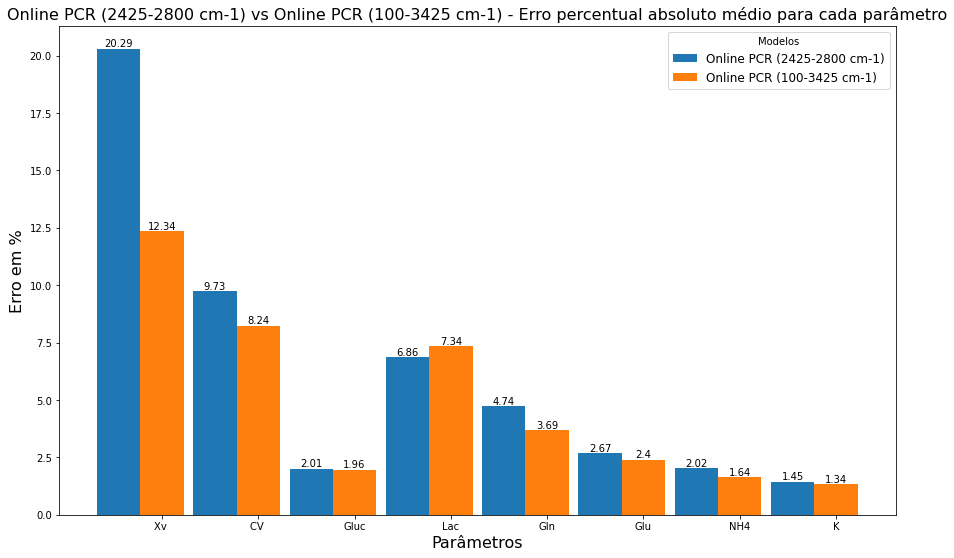

In [14]:
# choosing models

data_origin_1, spectral_range_1, model_category_1 = input('Enter the data origin (offline/online), spectral range and your model category for graph 1: ').split(' ')
data_origin_2, spectral_range_2, model_category_2 = input('Enter the data origin (offline/online), spectral range and your model category for graph 2: ').split(' ')

spectral_ranges = {"100-3425": "Best_models_100_3425",
                   "400-1850": "Best_models_400_1850",
                   "2425-2800": "Best_models_2425_2800",
                   "No_preprocessing": "Best_models_raw_100_3425"}

model_1 = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{spectral_ranges[spectral_range_1]}/{data_origin_1}_Best_{model_category_1}.pkl')
model_2 = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{spectral_ranges[spectral_range_2]}/{data_origin_2}_Best_{model_category_2}.pkl')

model_1 = pd.DataFrame(model_1).T[[2]]
model_2 = pd.DataFrame(model_2).T[[2]]

# offline data
errors_model_1 = model_1.values
errors_model_1 = [round(error[0], 4) * 100 for error in errors_model_1]

# online data
errors_model_2 = model_2.values
errors_model_2 = [round(error[0], 4) * 100 for error in errors_model_2]

# plotting comparison graph
fig, ax = plt.subplots(figsize=(15, 9))
x_pos = np.array(range(1, 9))

bars_on = ax.bar(x_pos-0.45, errors_model_1, 0.45, label=f'{data_origin_1} - {model_category_1}')
bars_off = ax.bar(x_pos, errors_model_2, 0.45, label=f'{data_origin_2} - {model_category_2}')

ax.bar_label(bars_on)
ax.bar_label(bars_off)

plt.xticks(x_pos, model_1.index.tolist())
plt.title(f'{data_origin_1} {model_category_1} ({spectral_range_1} cm-1) vs {data_origin_2} {model_category_2} ({spectral_range_2} cm-1) - Erro percentual absoluto médio para cada parâmetro',
          fontsize=16)
plt.xlabel('Parâmetros', fontsize=16)
plt.ylabel('Erro em %', fontsize=16)
plt.legend([f'{data_origin_1} {model_category_1} ({spectral_range_1} cm-1)',
                             f'{data_origin_2} {model_category_2} ({spectral_range_2} cm-1)'], 
                    title="Modelos",
                    loc='upper right', fontsize='large', fancybox=True)

#Online 2425-2800 PCR
#Online 400-1850 PCR

### Root mean squared errors comparison
---
- Any model and any data origin
- Xv can't be displayed alongside other parameters
- Has the folowing modes:

  > Xv or CV only / All other parameters

  > Training RSME comparison / Prediction RSME comparison

Please choose the kind of error to be dispalyed (Training/Prediction): Prediction
Enter the data origin (offline/online) and your model category for graph 1: Online MLR
Enter the data origin (offline/online) and your model category for graph 2: Offline MLR


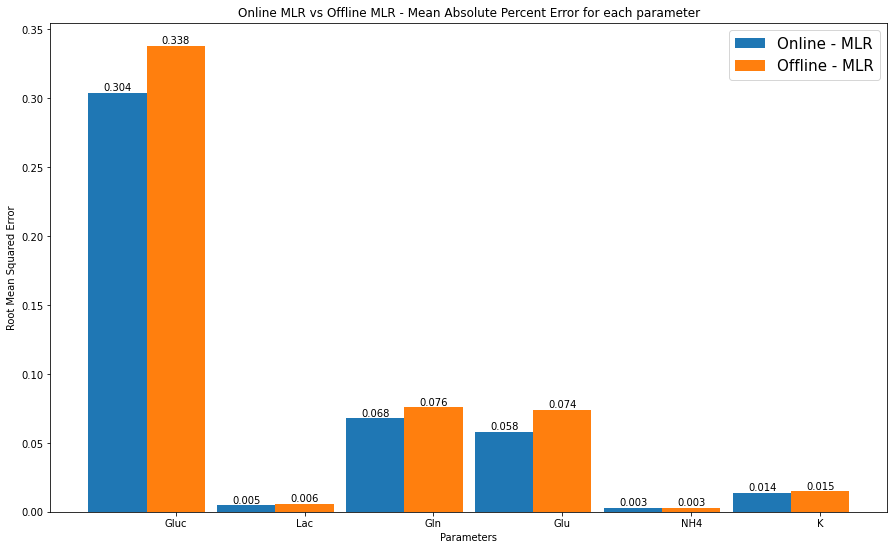

In [ ]:
# choosing models

mode = input('Please choose the kind of error to be dispalyed (Training/Prediction): ')
data_origin_1, model_category_1 = input('Enter the data origin (offline/online) and your model category for graph 1: ').split(' ')
data_origin_2, model_category_2 = input('Enter the data origin (offline/online) and your model category for graph 2: ').split(' ')

model_1 = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{data_origin_1}_Best_{model_category_1}.pkl')
model_2 = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{data_origin_2}_Best_{model_category_2}.pkl')

if mode == 'Training':
  model_1 = pd.DataFrame(model_1).T[[0]]
  model_2 = pd.DataFrame(model_2).T[[0]]

elif mode == 'Prediction':
  model_1 = pd.DataFrame(model_1).T[[1]]
  model_2 = pd.DataFrame(model_2).T[[1]]

# offline data]
errors_model_1 = model_1.values
errors_model_1 = [round(abs(*error), 3) for error in errors_model_1[2:]]

# online data
errors_model_2 = model_2.values
errors_model_2 = [round(abs(*error), 3) for error in errors_model_2[2:]]

# plotting comparison graph
fig, ax = plt.subplots(figsize=(15, 9))
x_pos = np.array(range(1, 7))

bars_on = ax.bar(x_pos-0.45, errors_model_1, 0.45, label=f'{data_origin_1} - {model_category_1}')
bars_off = ax.bar(x_pos, errors_model_2, 0.45, label=f'{data_origin_2} - {model_category_2}')

ax.bar_label(bars_on)
ax.bar_label(bars_off)

plt.xticks(x_pos, model_1.index.tolist()[2:])
plt.title(f'{data_origin_1} {model_category_1} vs {data_origin_2} {model_category_2} - Mean Absolute Percent Error for each parameter')
plt.xlabel('Parameters')
plt.ylabel('Root Mean Squared Error')
plt.legend(prop={'size': 15})

### Final results table
---
- Load all models of a given category (Online/Offline)
- Build an Excel file with the every model results

In [ ]:
# loading models
category = 'Online'

MLR_results = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{category}_Best_MLR.pkl')
PCR_results = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{category}_Best_PCR.pkl')
PLS_results = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{category}_Best_PLS.pkl')
SVR_results = joblib.load(f'/content/drive/MyDrive/TCC/Trained models/{category}_Best_SVR.pkl')

MLR_results = pd.DataFrame(MLR_results, index=['RMSE_MLR', 'Prediction RMSE_MLR', 'Prediction MAPE_MLR', 'Best Parameters', 'Best model']).drop(['Best model', 'Best Parameters'], axis=0)
PCR_results = pd.DataFrame(PCR_results, index=['RMSE_PCR', 'Prediction RMSE_PCR', 'Prediction MAPE_PCR', 'Best Parameters', 'Best model']).drop(['Best model', 'Best Parameters'], axis=0)
PLS_results = pd.DataFrame(PLS_results, index=['RMSE_PLS', 'Prediction RMSE_PLS', 'Prediction MAPE_PLS', 'Best Parameters', 'Best model']).drop(['Best model', 'Best Parameters'], axis=0)
SVR_results = pd.DataFrame(SVR_results, index=['RMSE_SVR', 'Prediction RMSE_SVR', 'Prediction MAPE_SVR', 'Best Parameters', 'Best model']).drop(['Best model', 'Best Parameters'], axis=0)

In [ ]:
pd.concat([MLR_results, PCR_results, PLS_results, SVR_results]).sort_index(ascending=False).T

,RMSE_SVR,RMSE_PLS,RMSE_PCR,RMSE_MLR,Prediction RMSE_SVR,Prediction RMSE_PLS,Prediction RMSE_PCR,Prediction RMSE_MLR,Prediction MAPE_SVR,Prediction MAPE_PLS,Prediction MAPE_PCR,Prediction MAPE_MLR
Xv,-2021394.813096,-3637893792453.862305,-329032.192227,-344785.338902,1871607.407053,1906755.564314,250288.921635,170461.076387,1.168177,1.414358,0.123439,0.116824
CV,-21.022832,-587.6509,-7.085678,-7.186819,21.697635,23.862339,3.87821,5.62991,0.71331,0.923768,0.082434,0.178855
Gluc,-0.761202,-0.809108,-0.365698,-0.399537,0.734624,0.927703,0.255116,0.304158,0.056559,0.070816,0.019581,0.022585
Lac,-0.046901,-0.000509,-0.00651,-0.007056,0.047055,0.021443,0.005485,0.005314,1.295701,0.352816,0.073447,0.073664
Gln,-0.173409,-0.094851,-0.099127,-0.095973,0.157825,0.324546,0.062124,0.067592,0.132629,0.414092,0.036881,0.053162
Glu,-0.142366,-0.046247,-0.070705,-0.074966,0.13095,0.204539,0.051059,0.057591,0.06923,0.098136,0.024024,0.026936
NH4,-0.013274,-0.00015,-0.002772,-0.00306,0.013179,0.012475,0.002063,0.002523,0.13252,0.121791,0.016389,0.020077
K,-0.034752,-0.001187,-0.014995,-0.016346,0.034784,0.03446,0.011707,0.013514,0.047719,0.046077,0.013361,0.016519


In [ ]:
all_results = PCA_results.join(SVR_results).join(MLR_results).join(PLS_results)
all_results = all_results[['MSE_MLR', 'MSE_PCA', 'MSE_PLS', 'MSE_SVR', 'Number of PCs', 'Best PLS Parameters', 'Best SVR Parameters']]
all_results.to_excel('Resultados Espectro Completo Offline - PCR MLR PLS SVR.xlsx')
all_results

df_online = pd.read_excel('Resultados Espectro Completo Online - PCR MLR PLS SVR.xlsx')
df_online = df_online[['MSE_MLR', 'MSE_PCA', 'MSE_PLS', 'MSE_SVR']].max(axis=1)
df_online.index = y.columns

df_offline = pd.read_excel('Resultados Espectro Completo Offline - PCR MLR PLS SVR.xlsx')
df_offline = df_offline[['MSE_MLR', 'MSE_PCA', 'MSE_PLS', 'MSE_SVR']].max(axis=1)
df_offline.index = y.columns

comparison = pd.concat([df_online, df_offline], axis=1)
comparison.columns = ['Online', 'Offline']
comparison['Diferença em %'] = round(abs((comparison['Offline'] - comparison['Online']) / comparison['Online'] * 100), 2)
comparison.to_excel('Comparação entre Online e Offline.xlsx')
comparison